In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.model_selection import train_test_split 
import nltk 
import joblib
import string
import re
from flask import Flask
from flask import request
%matplotlib inline
pd.set_option('display.max_colwidth', 100)
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/derickrentz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/derickrentz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Load dataset
def load_data():
    data = pd.read_csv('gold_reddit_corpus_agree.csv')
    return data

In [3]:
reddit_df = load_data()

<AxesSubplot:xlabel='cls', ylabel='count'>

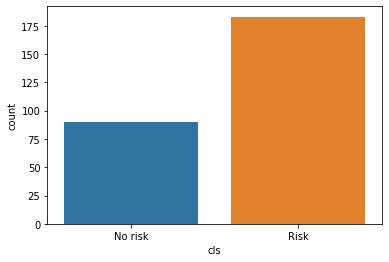

In [4]:
sns.countplot(x = 'cls', data = reddit_df)

In [5]:
df = pd.DataFrame(reddit_df[['text']])
df

,text
0,Insert random platitude here.
1,It's like this in Canada. Don't ever call a helpline. Their thereshold for calling the cops is p...
2,It has never occured to me before now that this also a method of suicide (although this was a fl...
3,"Obese people, regardless of their gender, make me shit."
4,The best way to spot a hyper-macho is knowing how much you love your mother. The most dangerous ...
...,...
268,I'm gonna end it all\nEverything is getting worse and worse. My parents value material things mo...
269,757 ppl online\nits comforting to know that theres ppl other than me who feel this way but why a...
270,"I've meticulously planned everything to the last detail, but whenever they ask me if I have a pl..."
271,"Fuck me\nI just want to go to sleep, and never wake up"


In [6]:
def clean_text(text):
    ps = nltk.PorterStemmer()
    stopword = nltk.corpus.stopwords.words('english')
    stopword.extend(['http', 'https'])
    
    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    return text

In [7]:
tfidfconverter = TfidfVectorizer(analyzer=clean_text, max_features=19)  
X = tfidfconverter.fit_transform(df['text'])
print('{} Number of texts has {} words'.format(X.shape[0], X.shape[1]))

273 Number of texts has 19 words


In [8]:
count_vect_df = pd.DataFrame(X.toarray(), columns=tfidfconverter.get_feature_names())
count_vect_df.head(100)

,day,dont,even,feel,fuck,get,go,im,kill,know,life,like,peopl,suicid,think,time,tri,want,would
0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.00000,0.762310,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.647212,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0
3,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.0
96,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
97,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
98,0.35715,0.313384,0.0,0.284107,0.0,0.29738,0.617715,0.316475,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.351217,0.000000,0.0


In [9]:
# Getting cls column
y = pd.DataFrame(reddit_df['cls']).values.ravel()
# y = y.values.ravel()

# Splitting train/test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

risk_count = 0
no_risk_count = 0

# Prints training data split
for i in y_train:
    if i == 'Risk':
        risk_count += 1
    else:
        no_risk_count += 1

print ("Risk: ", risk_count)
print ("No risk: ", no_risk_count)

Risk:  142
No risk:  76


In [10]:
# Training the model with training data
from sklearn.ensemble import RandomForestClassifier
text_classifier = RandomForestClassifier(n_estimators=100, random_state=0)  
text_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [11]:
# Doing predictions with test data
predictions = text_classifier.predict(X_test)

In [12]:
# Printing model metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
 
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(accuracy_score(y_test, predictions))

[[11  3]
 [ 0 41]]
              precision    recall  f1-score   support

     No risk       1.00      0.79      0.88        14
        Risk       0.93      1.00      0.96        41

    accuracy                           0.95        55
   macro avg       0.97      0.89      0.92        55
weighted avg       0.95      0.95      0.94        55

0.9454545454545454


In [ ]:
app = Flask(__name__)
@app.route('/classify', methods=['POST'])
def classifyText():
    text = request.json['text']
    vect_message = tfidfconverter.transform([text])
    classification = text_classifier.predict(vect_message)[0]
    print (text + ": " + classification)
    return classification

if __name__=="__main__":
    app.run()

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [24/Aug/2021 18:56:24] "POST /classify HTTP/1.1" 200 -


I hate everything: No risk


127.0.0.1 - - [24/Aug/2021 18:56:36] "POST /classify HTTP/1.1" 200 -


I feel so tired, so stressed, so empty. I don't know if I need to get drunk, take a hot bath and massages, a rainy day with coffee, miss classes for a week or I don't know. I feel like I hate everything, I don't tolerate anything.: Risk


127.0.0.1 - - [24/Aug/2021 18:56:56] "POST /classify HTTP/1.1" 200 -


I don't tolerate anything.: No risk


127.0.0.1 - - [24/Aug/2021 18:57:03] "POST /classify HTTP/1.1" 200 -


I feel so tired, so stressed, so empty. I don't know if I need to get drunk, take a hot bath and massages, a rainy day with coffee, miss classes for a week or I don't know. I feel like I hate everything: Risk


127.0.0.1 - - [24/Aug/2021 18:57:08] "POST /classify HTTP/1.1" 200 -


I feel so tired, so stressed, so empty. I don't know if I need to get drunk, take a hot bath and massages, a rainy day with coffee, miss classes for a week or I don't know.: No risk


127.0.0.1 - - [24/Aug/2021 18:57:15] "POST /classify HTTP/1.1" 200 -


 I feel like I hate everything: No risk


127.0.0.1 - - [24/Aug/2021 18:57:16] "POST /classify HTTP/1.1" 200 -


I feel like I hate everything: No risk


127.0.0.1 - - [24/Aug/2021 18:57:25] "POST /classify HTTP/1.1" 200 -


I feel so tired, so stressed, so empty. I don't know if I need to get drunk, take a hot bath and massages, a rainy day with coffee, miss classes for a week or I don't know.: No risk
